# Installation + imports

In [ ]:
!conda install -y mpi4py >> /dev/null

!git clone https://github.com/sreevishnu-damodaran/clip-diffusion-art.git -q
!pip install -e . -q
!git clone https://github.com/crowsonkb/guided-diffusion -q
!pip install -e guided-diffusion -q
!git clone https://github.com/JingyunLiang/SwinIR.git -q
!git clone https://github.com/openai/CLIP -q
!pip install -e ./CLIP -q

/bin/bash: line 1: conda: command not found
ERROR: file:///content does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.7/73.7 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 13.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 948.1 kB/s eta 0:00:00


In [ ]:
!pip install wandb
!pip install mpi4py
!pip install lpips
!pip install timm
!pip install openai==0.28

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.8/266.8 kB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 11.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for mpi4py: filename=mpi4py-3.1.6-cp310-cp310-linux_x86_64.whl size=2746324 sha256=df96c9b800821e8d514862ab2541f1e6e0f4825e53049d41706e90c4add30ba8
  Stored in directory: /root/.cache/pip/wheels/4c/ca/89/8fc1fb1c620afca13bb41c630b1f948bbf446e0aaa4b762e10
Successfully built mpi4py
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 9.6 MB/s eta 0:00:00
     ━━━

In [ ]:
import random
import os
import numpy as np

import sys
import yaml
import glob
from datetime import datetime

import matplotlib.pyplot as plt
from types import SimpleNamespace
import wandb

import torch
import torchvision
import torchvision.transforms.functional as TF

sys.path.append("./clip-diffusion-art")
sys.path.append("./guided-diffusion")
from clip_diffusion_art import logger
from clip_diffusion_art.train import TrainLoop
from clip_diffusion_art.cda_utils import (
    args_to_dict,
    add_dict_to_argparser,
)
from clip_diffusion_art.sample import ClipDiffusion

from guided_diffusion.script_util import (
    create_model_and_diffusion,
    model_and_diffusion_defaults
)
from guided_diffusion.image_datasets import load_data
from guided_diffusion.resample import create_named_schedule_sampler
from guided_diffusion import dist_util

import openai
import os
import csv
from itertools import islice


openai.api_key  = 'YOUR_API_KEY'

In [ ]:
def seed_all(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Fine-Tuning the model

As showed above, we need to clone clip-diffusion-art Git repository. It contains code to fine-tune the pre-trained OpenAI diffusion models. (Maybe it would be possible to check other OpenAI models and write the similar code ourselves). I did the training using these scripts:

In [ ]:
# setting the hyperparameters
MODEL_FLAGS="--image_size 256 --num_channels 128 --num_res_blocks 2 --num_heads 1 --attention_resolutions 16"
DIFFUSION_FLAGS="--diffusion_steps 1000 --noise_schedule linear --learn_sigma True --rescale_learned_sigmas True --rescale_timesteps True --use_scale_shift_norm False"
TRAIN_FLAGS="--lr 5e-6 --save_interval 500 --batch_size 16 --use_fp16 True --use_checkpoint True --resume_checkpoint pretrained_models/lsun_uncond_100M_1200K_bs128.pt"

# the script itself
python clip_diffusion_art/train.py --data_dir path/to/images $MODEL_FLAGS $DIFFUSION_FLAGS $TRAIN_FLAGS

# Description generation

In [ ]:
def generate_multiple_image_descriptions(article, model="gpt-3.5-turbo", num_descriptions=1):
    # Create a prompt that explicitly asks for multiple descriptions
    prompt = f"Generate {num_descriptions} distinct and vivid descriptions suitable for image generation from the following text: {article}"

    # Call the API using the chat completion endpoint
    response = openai.ChatCompletion.create(
        model=model,
        messages=[{"role": "user", "content": prompt}]
    )

    # Extract descriptions from the response
    # Assuming the model outputs multiple descriptions in a single response, separated clearly
    descriptions_raw = response.choices[0].message['content']

    # Split the descriptions assuming they are separated by two newlines or more
    descriptions = descriptions_raw.strip().split('\n\n')

    # Return the required number of descriptions, up to the number we asked for
    return descriptions[:num_descriptions]

In [ ]:
import requests
from bs4 import BeautifulSoup

def extract_text_from_url(url):
    if url:
        try:
            response = requests.get(url)
            response.raise_for_status()
            soup = BeautifulSoup(response.text, 'html.parser')
            title = soup.title.text if soup.title else 'No Title'
            paragraphs = soup.find_all('p')
            article_text = '\n'.join(p.text for p in paragraphs)
            full_text = f"{title}\n{article_text}"
            return full_text
        except requests.exceptions.RequestException as e:
            print("Access denied. The exception encountered is: ", e)
        except Exception as e:
            print("An error occurred during text extraction:", e)
    else:
        print("URL is empty.")
    return None

# Image generation

In [ ]:
cfg_dict = {
    "seed": 84,
    "model_config": "/content/drive/My Drive/Project - 30%/256x256_clip_diffusion_art.yaml",
    "checkpoint": "/content/drive/My Drive/Project - 30%/model001000.pt",
    "batch_size": 1,
    "skip_timesteps": 5,
    "sampling": "ddim50",
    "diffusion_steps": 1000,
    "clip_guidance_scale": 5000,
    "cutn": 60,
    "cutn_batches": 2,
    "scale_multiplier": 1,
    "tv_scale":75,
    "range_scale": 200,
    "loss_fn":"spherical",
    "clip_model": "ViT-B/16",
    "large_sr": True,
}

cfg_dict["output_dir"] = 'cfg_dict_ouput'

cfg = SimpleNamespace(**cfg_dict)

In [ ]:
seed_all(cfg.seed)

config_file = open(cfg.model_config)
model_config = yaml.load(config_file,
                         Loader=yaml.FullLoader)["model_config"]
print("model_config", model_config)

model_config {'attention_resolutions': '16', 'class_cond': False, 'rescale_timesteps': True, 'rescale_learned_sigmas': True, 'image_size': 256, 'learn_sigma': True, 'noise_schedule': 'linear', 'num_channels': 128, 'num_heads': 1, 'num_res_blocks': 2, 'use_checkpoint': False, 'use_fp16': 'True,', 'use_scale_shift_norm': False}


In [ ]:
clip_diffusion = ClipDiffusion(cfg.checkpoint,
    model_config=model_config,
    sampling=cfg.sampling,
    diffusion_steps=cfg.diffusion_steps,
    clip_model=cfg.clip_model,
    device=device
)

100%|████████████████████████████████████████| 335M/335M [00:02<00:00, 127MiB/s]


Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 150MB/s]


Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/vgg.pth


In [ ]:
def generate_images(prompts):

  num_samples = 4

  # Generate images using the clip_diffusion model
  out_generator = clip_diffusion.sample(
      prompts,
      num_samples=num_samples,
      batch_size=cfg.batch_size,
      skip_timesteps=cfg.skip_timesteps,
      cutn=cfg.cutn,
      cutn_batches=cfg.cutn_batches,
      loss_fn=cfg.loss_fn,
      clip_guidance_scale=cfg.clip_guidance_scale,
      tv_scale=cfg.tv_scale,
      range_scale=cfg.range_scale,
      scale_multiplier=cfg.scale_multiplier,
      output_dir=cfg.output_dir
  )

  # Ensure the output directory exists
  os.makedirs(cfg.output_dir, exist_ok=True)

  # Display and save the images
  for i, out_image in enumerate(out_generator):
      disp_image = TF.to_pil_image(out_image.squeeze(0))  # Convert tensor to PIL Image

      # Display the image using matplotlib
      plt.figure(figsize=(10, 12))
      plt.imshow(disp_image)
      plt.axis('off')
      plt.show()

      # Save the image to disk
      current_time = datetime.now().strftime('%y%m%d-%H%M%S_%f')
      filename = f'image{i}_{current_time}.png'
      disp_image.save(os.path.join(cfg.output_dir, filename))


As the sun set behind the forest, the sheep dogs barked frantically and the flock ran around in a panic, their bleating filling the air. The old man on the hill watched in horror as the wolf seized a lamb, crying out for help, but knowing deep down that nobody would come to his aid.


0step [00:00, ?step/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Sample 0 : : 44step [01:04,  1.43s/step, output=0, step=43]

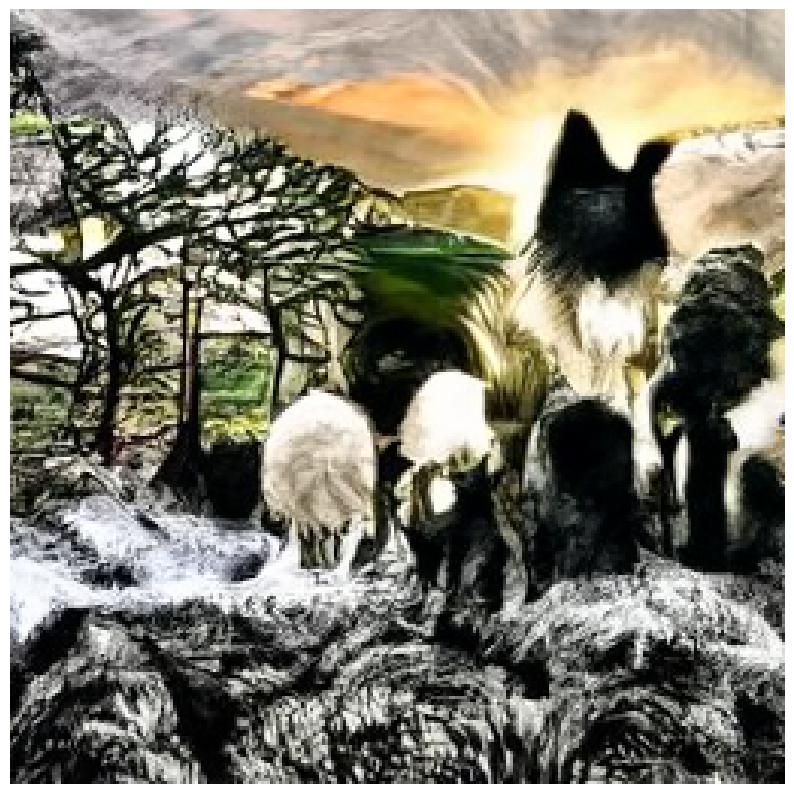

Sample 0 : : 45step [01:05,  1.59s/step, output=0, step=44]

In [ ]:
url_to_extract = 'https://www.storynory.com/the-boy-who-cried-wolf/'
input_text = extract_text_from_url(url_to_extract)
if input_text:
    descriptions = generate_multiple_image_descriptions(input_text)

print(descriptions[0])
generate_images(descriptions)

# What i did before


0step [00:00, ?step/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Sample 0 : : 44step [01:09,  1.50s/step, output=0, step=43]

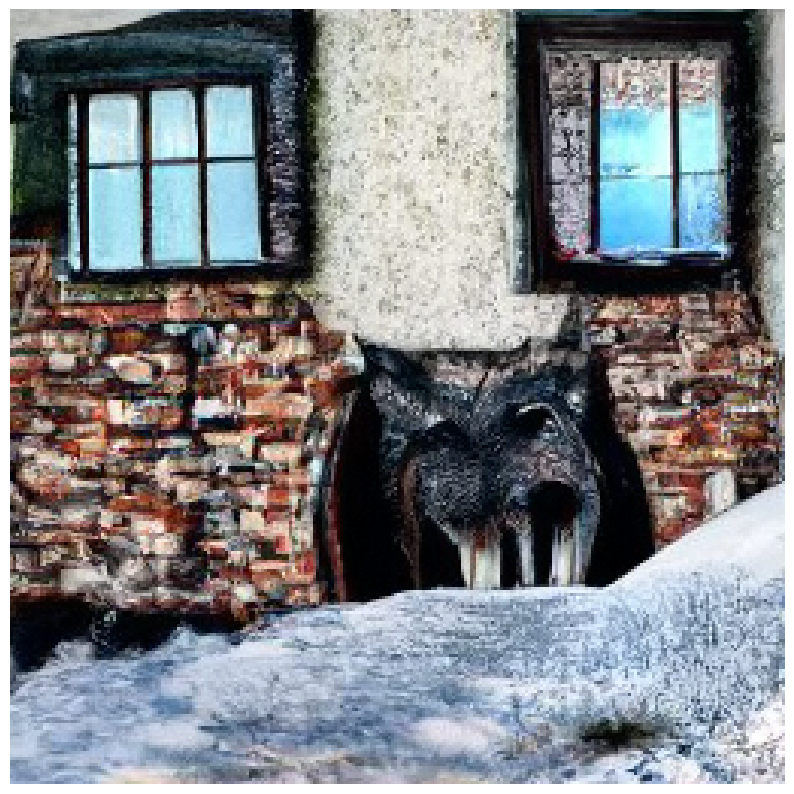

Sample 0 : : 45step [01:10,  1.56s/step, output=0, step=44]
0step [00:00, ?step/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Sample 1 : : 26step [00:45,  1.73s/step, output=0, step=25]


KeyboardInterrupt: 

In [ ]:
prompts = ["The wolf, with his sinister grin and cunning eyes, stands outside the grandmother's house, ready to deceive Little Red Riding Hood and carry out his evil plan"]
num_samples = 4

# Generate images using the clip_diffusion model
out_generator = clip_diffusion.sample(
    prompts,
    num_samples=num_samples,
    batch_size=cfg.batch_size,
    skip_timesteps=cfg.skip_timesteps,
    cutn=cfg.cutn,
    cutn_batches=cfg.cutn_batches,
    loss_fn=cfg.loss_fn,
    clip_guidance_scale=cfg.clip_guidance_scale,
    tv_scale=cfg.tv_scale,
    range_scale=cfg.range_scale,
    scale_multiplier=cfg.scale_multiplier,
    output_dir=cfg.output_dir
)

# Ensure the output directory exists
os.makedirs(cfg.output_dir, exist_ok=True)

# Display and save the images
for i, out_image in enumerate(out_generator):
    disp_image = TF.to_pil_image(out_image.squeeze(0))  # Convert tensor to PIL Image

    # Display the image using matplotlib
    plt.figure(figsize=(10, 12))
    plt.imshow(disp_image)
    plt.axis('off')
    plt.show()

    # Save the image to disk
    current_time = datetime.now().strftime('%y%m%d-%H%M%S_%f')
    filename = f'image{i}_{current_time}.png'
    disp_image.save(os.path.join(cfg.output_dir, filename))

0step [00:00, ?step/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Sample 0 : : 44step [01:07,  1.47s/step, output=0, step=43]

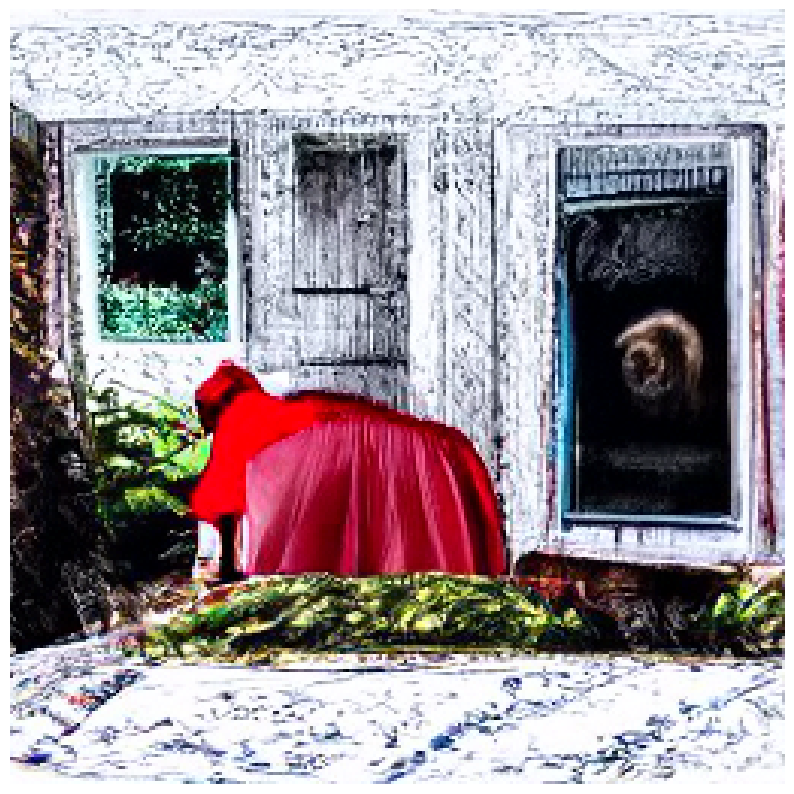

Sample 0 : : 45step [01:08,  1.52s/step, output=0, step=44]
0step [00:00, ?step/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Sample 1 : : 44step [01:07,  1.49s/step, output=0, step=43]

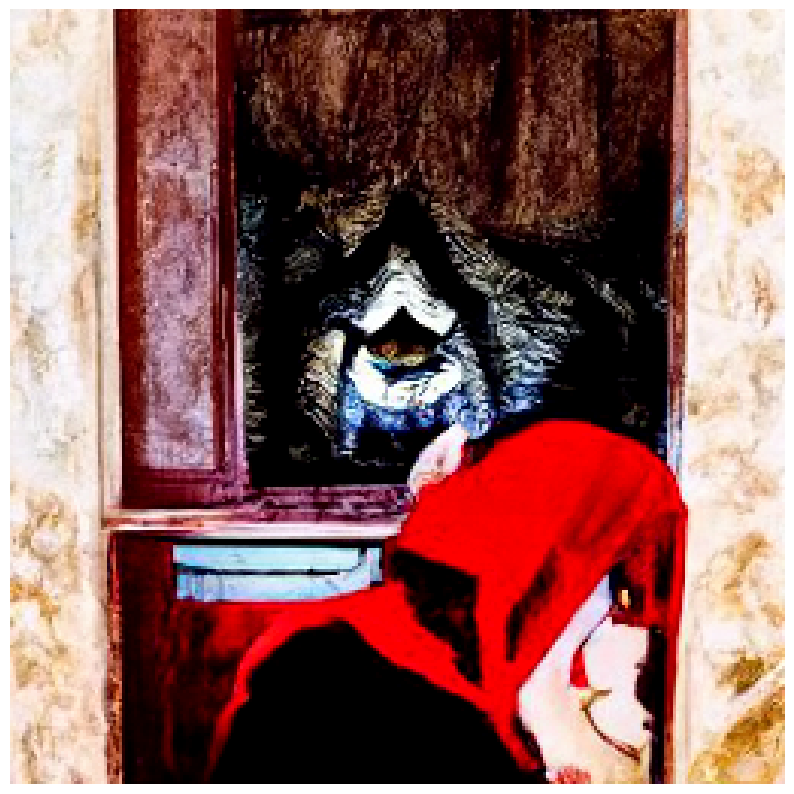

Sample 1 : : 45step [01:08,  1.52s/step, output=0, step=44]
0step [00:00, ?step/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Sample 2 : : 44step [01:07,  1.48s/step, output=0, step=43]

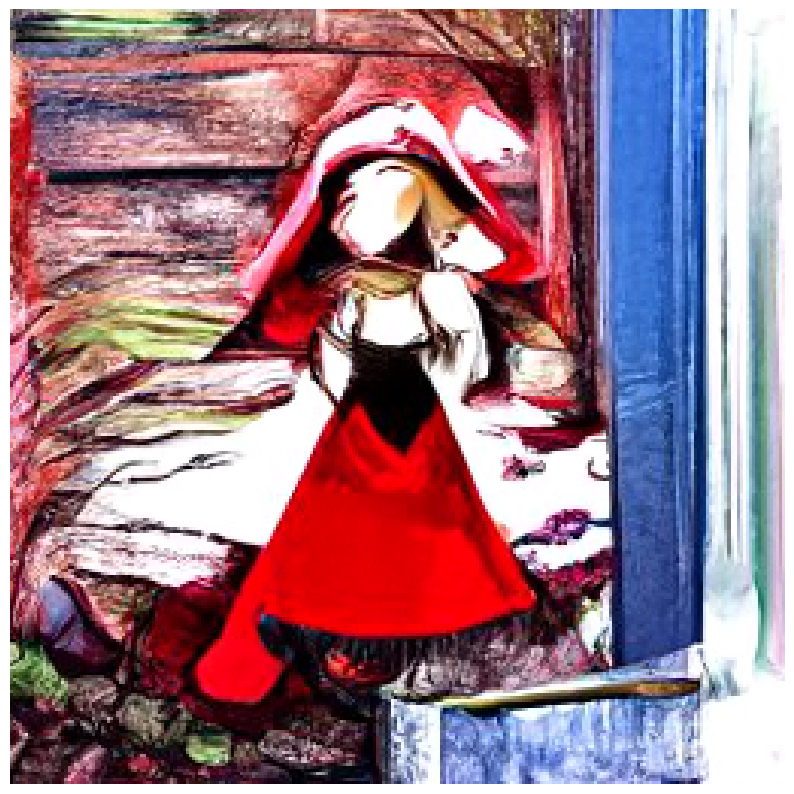

Sample 2 : : 45step [01:07,  1.51s/step, output=0, step=44]
0step [00:00, ?step/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Sample 3 : : 44step [01:07,  1.48s/step, output=0, step=43]

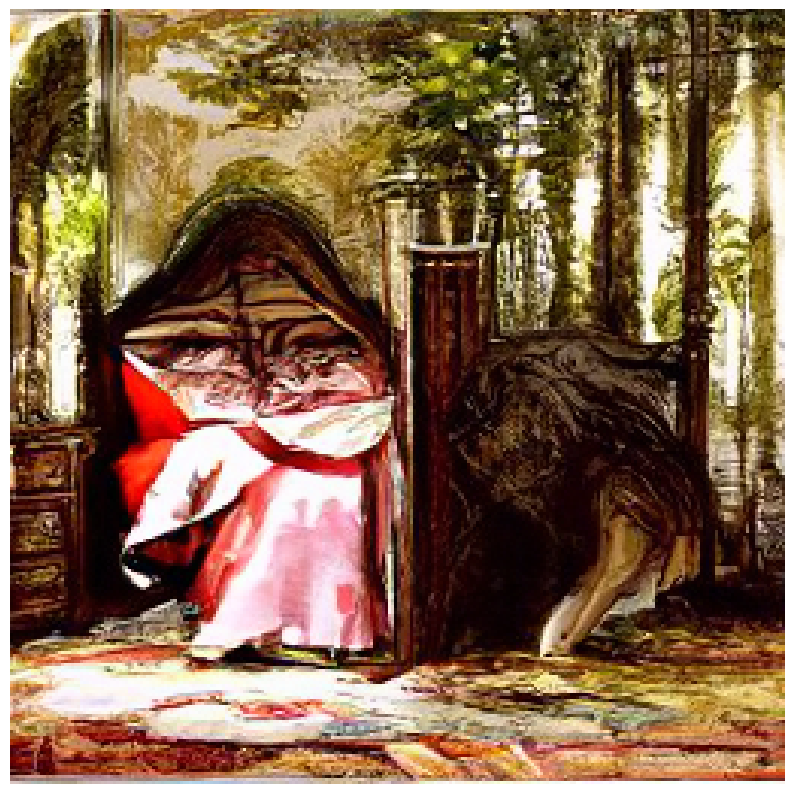

Sample 3 : : 45step [01:07,  1.51s/step, output=0, step=44]


In [ ]:
prompts = ["The image of Little Red Riding Hood standing at her grandmother's door, unknowingly facing the wolf disguised as her beloved grandmother, sends chills down the spine as the inevitable danger looms near"]
num_samples = 4

# Generate images using the clip_diffusion model
out_generator = clip_diffusion.sample(
    prompts,
    num_samples=num_samples,
    batch_size=cfg.batch_size,
    skip_timesteps=cfg.skip_timesteps,
    cutn=cfg.cutn,
    cutn_batches=cfg.cutn_batches,
    loss_fn=cfg.loss_fn,
    clip_guidance_scale=cfg.clip_guidance_scale,
    tv_scale=cfg.tv_scale,
    range_scale=cfg.range_scale,
    scale_multiplier=cfg.scale_multiplier,
    output_dir=cfg.output_dir
)

# Ensure the output directory exists
os.makedirs(cfg.output_dir, exist_ok=True)

# Display and save the images
for i, out_image in enumerate(out_generator):
    disp_image = TF.to_pil_image(out_image.squeeze(0))  # Convert tensor to PIL Image

    # Display the image using matplotlib
    plt.figure(figsize=(10, 12))
    plt.imshow(disp_image)
    plt.axis('off')
    plt.show()

    # Save the image to disk
    current_time = datetime.now().strftime('%y%m%d-%H%M%S_%f')
    filename = f'image{i}_{current_time}.png'
    disp_image.save(os.path.join(cfg.output_dir, filename))

# Without fine-tune


In [ ]:
cfg_dict = {
    "seed": 84,
    "wandb_project": "clip_diffusion_art",
    "wandb_name": "job7",
    "model_config": "/content/drive/My Drive/labs/Project - 30%/256x256_clip_diffusion_art.yaml",
    "checkpoint": "/content/drive/My Drive/labs/Project - 30%/lsun_uncond_100M_1200K_bs128.pt",
    "batch_size": 1,
    "skip_timesteps": 5,
    "sampling": "ddim50",
    "diffusion_steps": 1000,
    "clip_guidance_scale": 5000,
    "cutn": 60,
    "cutn_batches": 2,
    "scale_multiplier": 1,
    "tv_scale":75,
    "range_scale": 200,
    "loss_fn":"spherical",
    "clip_model": "ViT-B/16",
    "large_sr": True,
}

cfg_dict["output_dir"] = 'cfg_dict_ouput'

cfg = SimpleNamespace(**cfg_dict)

In [ ]:
seed_all(cfg.seed)

config_file = open(cfg.model_config)
model_config = yaml.load(config_file,
                         Loader=yaml.FullLoader)["model_config"]
print("model_config", model_config)

model_config {'attention_resolutions': '16', 'class_cond': False, 'rescale_timesteps': True, 'rescale_learned_sigmas': True, 'image_size': 256, 'learn_sigma': True, 'noise_schedule': 'linear', 'num_channels': 128, 'num_heads': 1, 'num_res_blocks': 2, 'use_checkpoint': False, 'use_fp16': 'True,', 'use_scale_shift_norm': False}


In [ ]:
clip_diffusion = ClipDiffusion(cfg.checkpoint,
    model_config=model_config,
    sampling=cfg.sampling,
    diffusion_steps=cfg.diffusion_steps,
    clip_model=cfg.clip_model,
    device=device
)

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/vgg.pth


0step [00:00, ?step/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Sample 0 : : 44step [01:07,  1.55s/step, output=0, step=43]

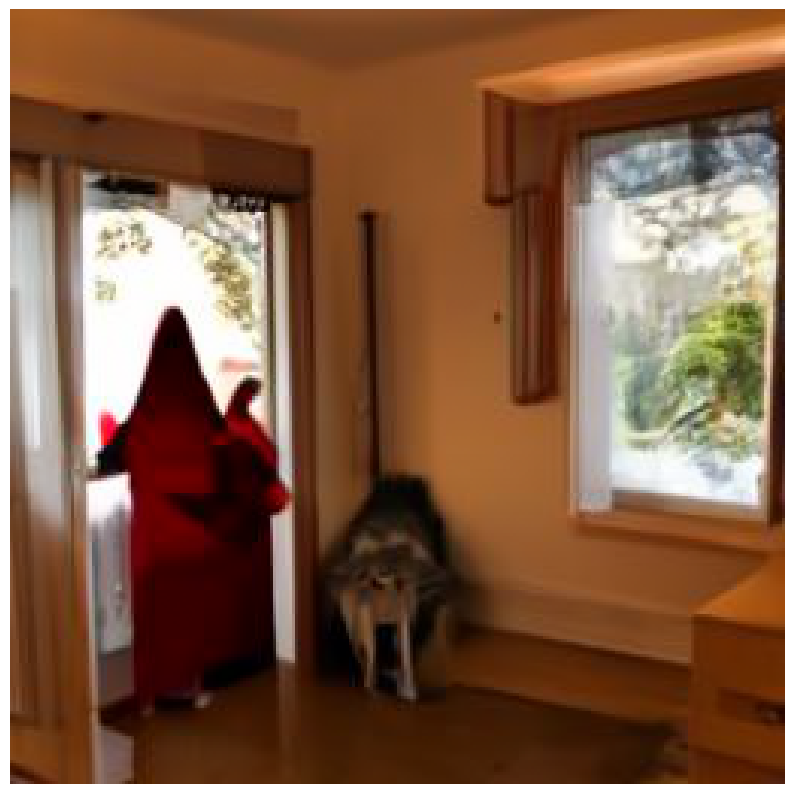

Sample 0 : : 45step [01:08,  1.52s/step, output=0, step=44]
0step [00:00, ?step/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Sample 1 : : 44step [01:08,  1.52s/step, output=0, step=43]

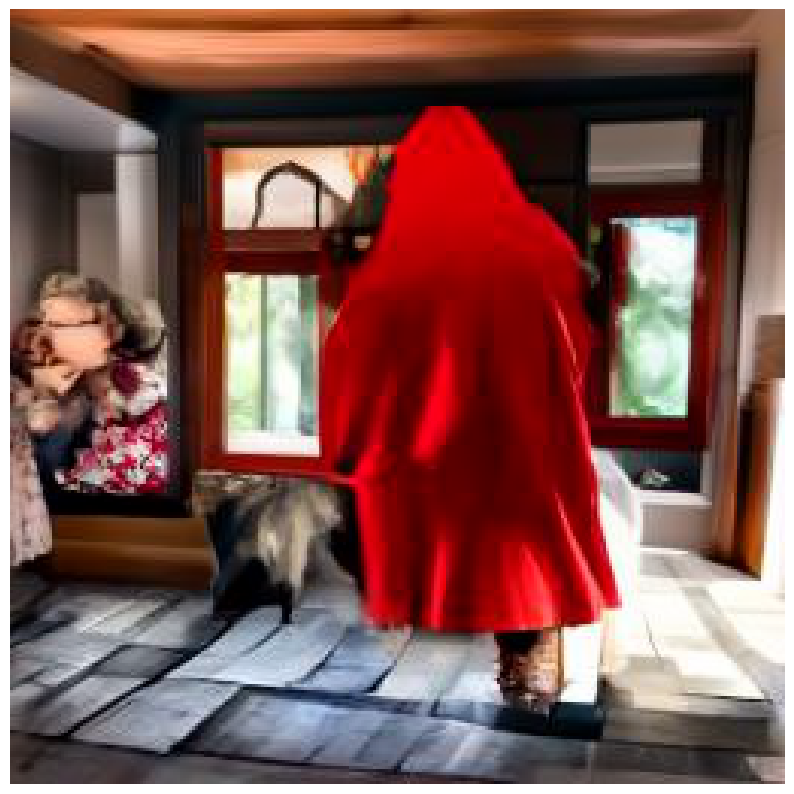

Sample 1 : : 45step [01:09,  1.54s/step, output=0, step=44]
0step [00:00, ?step/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Sample 2 : : 44step [01:07,  1.52s/step, output=0, step=43]

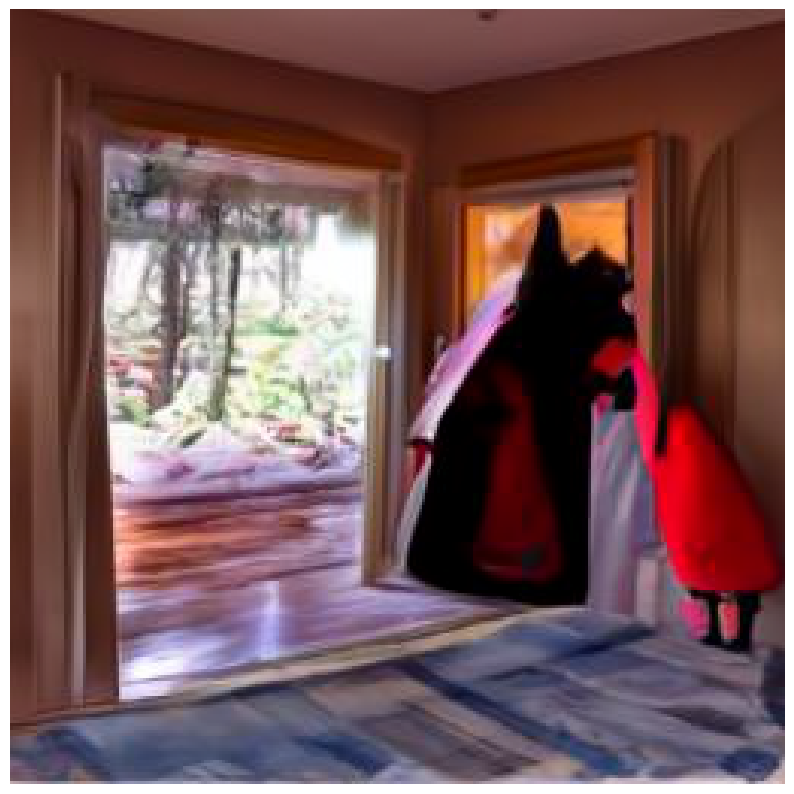

Sample 2 : : 45step [01:08,  1.51s/step, output=0, step=44]
0step [00:00, ?step/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Sample 3 : : 44step [01:07,  1.51s/step, output=0, step=43]

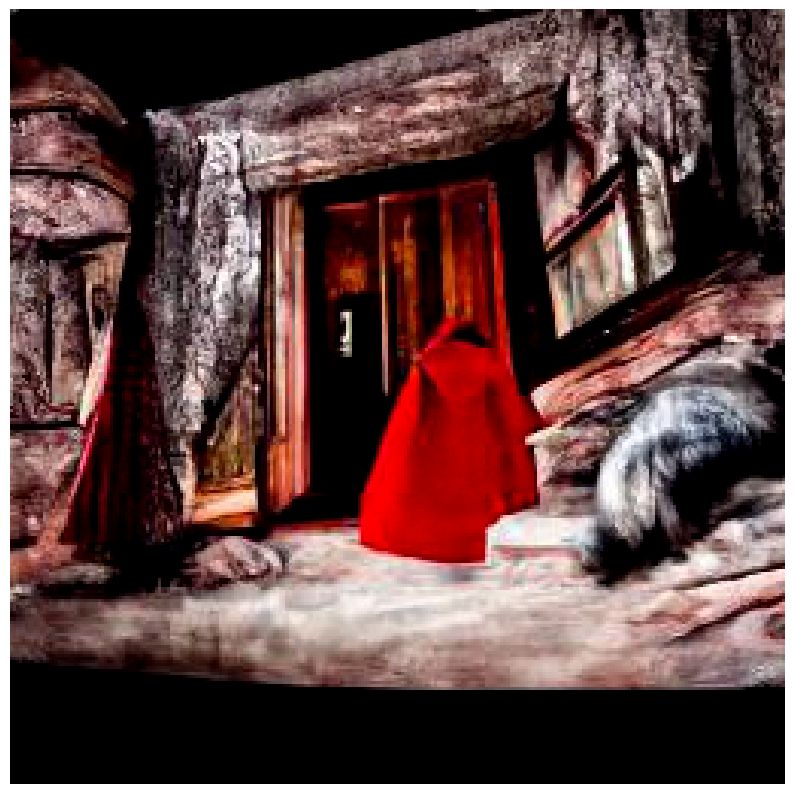

Sample 3 : : 45step [01:07,  1.51s/step, output=0, step=44]


In [ ]:
prompts = ["The image of Little Red Riding Hood standing at her grandmother's door, unknowingly facing the wolf disguised as her beloved grandmother, sends chills down the spine as the inevitable danger looms near"]
num_samples = 4

# Generate images using the clip_diffusion model
out_generator = clip_diffusion.sample(
    prompts,
    num_samples=num_samples,
    batch_size=cfg.batch_size,
    skip_timesteps=cfg.skip_timesteps,
    cutn=cfg.cutn,
    cutn_batches=cfg.cutn_batches,
    loss_fn=cfg.loss_fn,
    clip_guidance_scale=cfg.clip_guidance_scale,
    tv_scale=cfg.tv_scale,
    range_scale=cfg.range_scale,
    scale_multiplier=cfg.scale_multiplier,
    output_dir=cfg.output_dir
)

# Ensure the output directory exists
os.makedirs(cfg.output_dir, exist_ok=True)

# Display and save the images
for i, out_image in enumerate(out_generator):
    disp_image = TF.to_pil_image(out_image.squeeze(0))  # Convert tensor to PIL Image

    # Display the image using matplotlib
    plt.figure(figsize=(10, 12))
    plt.imshow(disp_image)
    plt.axis('off')
    plt.show()

    # Save the image to disk
    current_time = datetime.now().strftime('%y%m%d-%H%M%S_%f')
    filename = f'image{i}_{current_time}.png'
    disp_image.save(os.path.join(cfg.output_dir, filename))

In [ ]:
import torch
import torch.nn as nn

def load_model(model_path):
    # Load the model checkpoint
    model = torch.load(model_path, map_location=torch.device('cpu'))

    # Assuming the model architecture is included in the checkpoint
    return model

def print_model_summary(model):
    # Print the model architecture
    print("Model Architecture:")
    print(model)


def test_input_shape(model):
    # Assuming the model is for image inputs, attempt a forward pass with a dummy input
    # You might need to adjust the size depending on the expected input of the model
    try:
        dummy_input = torch.randn(1, 3, 224, 224)  # Example size for a typical image model
        output = model(dummy_input)
        print("Successful forward pass. Output shape:", output.shape)
    except Exception as e:
        print("Failed to perform forward pass. Error:", str(e))

# Path to your model .pt file
model_path = '/content/drive/My Drive/labs/Project - 30%/model001000.pt'

# Load the model
model = load_model(model_path)

# Print the model summary
print_model_summary(model)




Выходные данные были обрезаны до нескольких последних строк (5000).
        -7.8966e-01, -5.9385e-02, -3.4402e-01, -4.6044e-01, -2.9382e-01,
        -3.2676e-01, -3.3152e-01, -7.5609e-02, -6.4085e-02, -3.2913e-01,
        -1.6576e-01, -3.4540e-01, -2.7681e-01, -2.3533e-01, -8.3392e-02,
        -7.3049e-02,  5.5287e-02, -9.4853e-02, -1.9319e-01, -3.9290e-01,
         9.0745e-02, -3.5137e-01, -2.5741e-01, -2.4996e-01, -2.1268e-01,
         1.1587e-02, -3.0924e-02, -1.6841e-01, -4.5147e-02, -1.9025e-01,
        -1.2300e-01, -3.9768e-04, -1.6725e-01, -5.2188e-01, -1.6910e-01,
        -5.8025e-02, -2.6870e-01, -4.5374e-02, -2.9842e-01, -4.0112e-01,
        -1.0071e-01, -9.2917e-02, -6.8295e-02, -4.3646e-01, -3.3178e-02,
         2.5202e-02, -8.1754e-02, -2.5346e-01,  1.3858e-02, -2.7985e-01,
        -9.4302e-02, -8.1039e-03,  4.0548e-02, -9.1593e-02, -1.2929e-01,
        -3.1710e-02,  1.7474e-02, -3.1012e-02, -4.3436e-02, -1.5871e-02,
         9.2251e-02,  5.8913e-03, -2.0655e-01,  4.6969e-